In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets import load_digits 
import seaborn as sns 
from scipy.spatial.distance import pdist,squareform 
from scipy.stats import zscore 
from skimage.measure import block_reduce 
from progress.bar import Bar 
import progressbar 
import networkx as nx
sns.set()
import sys; sys.stdout.flush()

## Start by performing affinity propagation on MNIST dataset

- for shared preference, median of input similarities will produce a moderate number of clusters
    - or minimum input similarity if we want fewer clusters 
    - can plot shared preference vs number of clusters ala Fig1D to see this
    - with inclusion of more datapts, need shared pref value lower than min to get 10 clusters

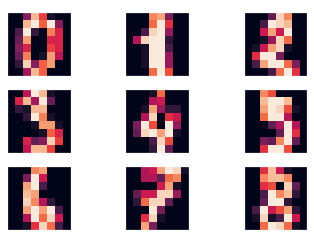

In [2]:
# load MNIST dataset
X, y = load_digits(return_X_y=True)
X.shape

fig, axes = plt.subplots(3,3, sharey='row', sharex='col')
# display MNIST data
for col in range(3):
    for row in range(3):
        axes[col,row].matshow(X[col*3+row,:].reshape(8,8)) 
        axes[col,row].set_xticks([])
        axes[col,row].set_yticks([])


In [3]:
# calculate similarity matrix
data_pts = 100 # start w/ fewer datapts to speed things up
S = -squareform(pdist(X[:data_pts],'sqeuclidean')) # distance metric
pref_med = np.median(S) 
pref_min = np.min(S)
print('Median S: %f \n'%pref_med)
print('Min S: %f \n'%pref_min)

Median S: -2396.500000 

Min S: -4747.000000 



In [4]:
# perform affinity clustering, analyzing number of clusters returned across preference parameter  
pref_tests = list(range(-10000,0,200))
n_clusters = np.zeros(len(pref_tests)) 
for i,pref in enumerate(pref_tests):
    AP_clustering = AffinityPropagation(affinity = 'precomputed',preference = pref,random_state=5) 
    labels = AP_clustering.fit_predict(S)
    n_clusters[i] = len(np.unique(labels))


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "


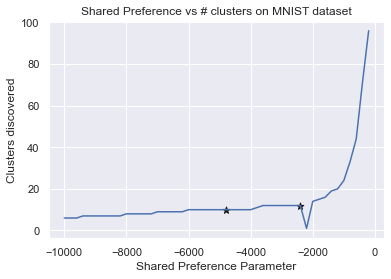

In [5]:
# display results
sns.set()
plt.figure()
plt.plot(pref_tests,n_clusters) 
plt.title("Shared Preference vs # clusters on MNIST dataset") 
plt.xlabel("Shared Preference Parameter")
plt.ylabel("Clusters discovered")  
# mark number of clusters discovered by min,med S values
closest_ix = pref_tests.index(pref_med - pref_med % 200)
plt.scatter(pref_med - pref_med % 200,n_clusters[closest_ix],marker = '*',color = 'k',s = 50)
closest_ix = pref_tests.index(pref_min - pref_min % 200)
plt.scatter(pref_min - pref_min % 200,n_clusters[closest_ix],marker = '*',color = 'k',s = 50);

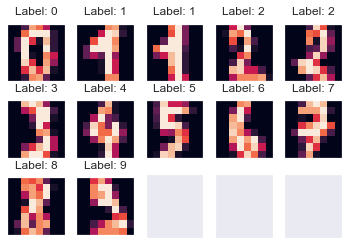

In [8]:
# visualize the discovered centroids
AP_clustering = AffinityPropagation(affinity = 'precomputed',preference = pref_med,random_state = 5) 
labels = AP_clustering.fit_predict(S) 
clusteroid_ix = AP_clustering.cluster_centers_indices_
clusteroid_ix = clusteroid_ix[np.argsort(y[clusteroid_ix])] # sort by label

fig, axes = plt.subplots(int(np.ceil(len(clusteroid_ix) / 5)),5, sharey='row', sharex='col')
# display MNIST data centroids
for i,c_idx in enumerate(clusteroid_ix): 
    row = int(np.floor(i / 5)) 
    col = i % 5
    axes[row,col].matshow(X[c_idx,:].reshape(8,8)) 
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([]) 
    axes[row,col].set_title("Label: %i"%y[c_idx])

## Now load in neural data and get spicy
- start by averaging activity every 0.25 seconds to decr datapts 

In [2]:
import scipy.io as sio
# load in .mat file
data = sio.loadmat('/Users/joshstern/Documents/UchidaLab_matlab/neuroPixelsData/80/processed_data/m80FR_decVar.mat')
FR_decVar = data['FR_decVar'][0] 
timeSort_data = sio.loadmat('/Users/joshstern/Documents/UchidaLab_matlab/neuroPixelsData/80/processed_data/m80timeSort.mat')
timeSort = timeSort_data['index_sort_all'][0]
timesinceSort_data = sio.loadmat('/Users/joshstern/Documents/UchidaLab_matlab/neuroPixelsData/80/processed_data/m80timesinceSort.mat')
timesinceSort = timesinceSort_data['index_sort_all'][0]
tbin_ms = .02 *1000

In [3]:
# ok, let's grab some neural data
sIdx = 2 # 3/17 
sort_sIdx = timesinceSort[sIdx] - 1
fr_mat = FR_decVar[sIdx]['fr_mat'][0]
fr_mat_full = np.squeeze(np.concatenate(fr_mat,1)[sort_sIdx,:]) # sort by time
fr_mat_full.shape

(305, 26668)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


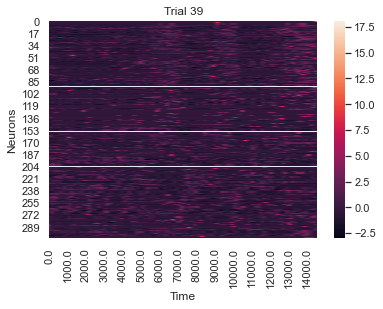

In [4]:
# get some trial information and visualize a single trial
nTrials = fr_mat.shape[0]
t_lens = [fr_mat_iTrial.shape[1] for fr_mat_iTrial in fr_mat.tolist()] 
prts = np.array(t_lens)  * tbin_ms / 1000
patchleave_ix = np.cumsum(t_lens)
patchstop_ix = patchleave_ix - t_lens 
trial = 38
plt.figure()
plt.title("Trial %i"%(trial+1))
sns.heatmap(np.flipud(zscore(fr_mat_full[:,patchstop_ix[trial]:patchleave_ix[trial]],1)))
plt.xlabel("Time")
plt.ylabel("Neurons")
sec_ix = np.array(range(0,t_lens[trial],round((1000/tbin_ms))))
plt.xticks(sec_ix,sec_ix * tbin_ms);

(305, 60)

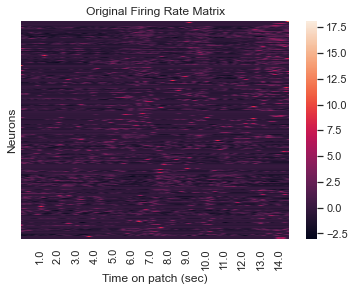

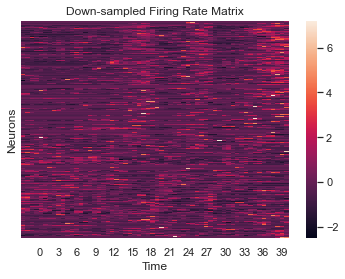

In [5]:
# Demonstrate what's going on in reduction step
avg_window = int(250 / tbin_ms) 
# for iTrial in [38]: # range(2):  
iTrial = 38
fr_mat_iTrial = np.squeeze(fr_mat[iTrial][sort_sIdx,:])
fr_mat_iTrial = zscore(fr_mat_iTrial,1) 
fr_mat_iTrial[np.isnan(fr_mat_iTrial)] = 0 
if (t_lens[iTrial] % avg_window) > 0:
    fr_mat_iTrial_cutdown = fr_mat_iTrial[:,:-(t_lens[iTrial] % avg_window)] 
else: 
    fr_mat_iTrial_cutdown = fr_mat_iTrial
fr_mat_iTrial_cutdown = np.mean(fr_mat_iTrial_cutdown.reshape(fr_mat_iTrial_cutdown.shape[0],-1, avg_window), axis=2) 
# leftover = np.mean(fr_mat_iTrial[:,-(t_lens[iTrial] % avg_window):],axis=1)
# reduced_fr_mat = np.concatenate((fr_mat_iTrial_cutdown,leftover[:,np.newaxis]),1) 
reduced_fr_mat = fr_mat_iTrial_cutdown

# visualize the reduction
plt.figure()
sns.heatmap(np.flipud(fr_mat_iTrial))   
plt.title("Original Firing Rate Matrix") 
plt.xlabel("Time on patch (sec)") 
plt.ylabel("Neurons") 
plt.yticks([]) 
plt.xticks([50,100,150,200,250,300,350,400,450,500,550,600,650,700],tbin_ms / 1000 * np.array([50,100,150,200,250,300,350,400,450,500,550,600,650,700]))
plt.figure() 
sns.heatmap(np.flipud(reduced_fr_mat)); 
plt.title("Down-sampled Firing Rate Matrix") 
plt.xlabel("Time") 
plt.xticks(np.array([50,100,150,200,250,300,350,400,450,500,550,600,650,700]) / avg_window,)
plt.ylabel("Neurons") 
plt.yticks([]) 
reduced_fr_mat.shape 

In [6]:
# iterate over trials, perform reduction step, concatenate into new matrix where we will perform AP 
avg_window_ms = 250
avg_window = int(250 / tbin_ms) 
reduced_fr_mat = [] 
lens = []
for iTrial in range(nTrials):
    fr_mat_iTrial = np.squeeze(fr_mat[iTrial][sort_sIdx,:])
    fr_mat_iTrial = zscore(fr_mat_iTrial,1) 
    fr_mat_iTrial[np.isnan(fr_mat_iTrial)] = 0 
    if (t_lens[iTrial] % avg_window) > 0:
        fr_mat_iTrial_cutdown = fr_mat_iTrial[:,:-(t_lens[iTrial] % avg_window)] 
    else: 
        fr_mat_iTrial_cutdown = fr_mat_iTrial
    fr_mat_iTrial_cutdown = np.mean(fr_mat_iTrial_cutdown.reshape(fr_mat_iTrial_cutdown.shape[0],-1, avg_window), axis=2) 
#     leftover = np.mean(fr_mat_iTrial[:,-(t_lens[iTrial] % avg_window):],axis=1)
#     reduced_fr_mat_iTrial = np.concatenate((fr_mat_iTrial_cutdown,leftover[:,np.newaxis]),1)
    reduced_fr_mat.append(fr_mat_iTrial_cutdown)  
    lens.append(fr_mat_iTrial_cutdown.shape[1])
reduced_fr_mat = np.concatenate(reduced_fr_mat,1)
reduced_fr_mat[np.isnan(reduced_fr_mat)] = 0 
reduced_fr_mat.shape



(305, 2145)

## Cluster discovery assays over shared preference parameters 

In [7]:
def sharedPreferenceAssay(data,metric,test_padding,test_interval,data_pts = 'all',max_iter = 200):
    # calculate similarity matrix
    if data_pts == 'all':
        S = -squareform(pdist(data,metric)) # distance metric 
    else: 
        S = -squareform(pdist(data[:data_pts,:],metric)) # distance metric 
    pref_med = int(round(np.median(S)))
    pref_min = int(round(np.min(S))) 
    print('S dimensionality: %i x %i \n'%(S.shape[0],S.shape[1]))
    print('Median S: %f \n'%pref_med)
    print('Min S: %f \n'%pref_min)  
    
    # perform affinity clustering, analyzing number of clusters returned across preference parameter  
    pref_tests = list(range((pref_min - pref_min % test_interval)-test_padding,(pref_med - pref_med % test_interval)+test_padding,test_interval))
    n_clusters = np.zeros(len(pref_tests))  
    for i,pref in enumerate(pref_tests):
        AP_clustering = AffinityPropagation(affinity = 'precomputed',preference = pref,random_state=1,max_iter = max_iter) 
        labels = AP_clustering.fit_predict(S)
        n_clusters[i] = len(np.unique(labels)) 
        if i % 5 == 0: 
            print("Test %i complete \t"%i)

    # visualize results
    sns.set()
    plt.figure()
    plt.plot(pref_tests[:len(np.where(n_clusters > 0)[0])],n_clusters[:len(np.where(n_clusters > 0)[0])]) 
    plt.title("Shared Preference vs # clusters (-%s Similarity)"%metric) 
    plt.xlabel("Shared Preference Parameter")
    plt.ylabel("Clusters discovered")  
    # mark number of clusters discovered by min,med S values
    closest_ix = pref_tests.index(pref_med - pref_med % test_interval)
    plt.scatter(pref_med - pref_med % test_interval,n_clusters[closest_ix],marker = '*',color = 'k',s = 50)
    closest_ix = pref_tests.index(pref_min - pref_min % test_interval)
    plt.scatter(pref_min - pref_min % test_interval,n_clusters[closest_ix],marker = '*',color = 'k',s = 50); 
    plt.savefig("sharedPrefPlot")  
    return pref_tests,n_clusters
    

S dimensionality: 2145 x 2145 

Median S: -390.000000 

Min S: -1207.000000 

Test 0 complete 	
Test 5 complete 	
Test 10 complete 	


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "


Test 15 complete 	


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "


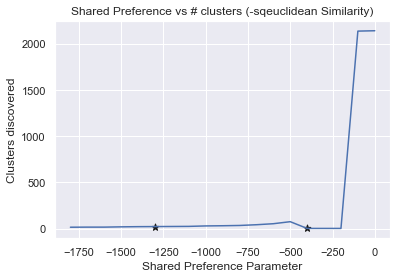

In [8]:
pref_tests,n_clusters = sharedPreferenceAssay(reduced_fr_mat.T,'sqeuclidean',500,100,data_pts = 'all',max_iter = 100) 


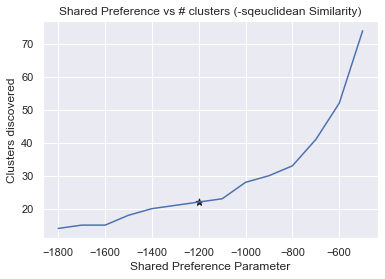

In [18]:
sns.set()
plt.figure()
plt.plot(pref_tests[:-5],n_clusters[:-5]) 
plt.title("Shared Preference vs # clusters (-sqeuclidean Similarity)") 
plt.xlabel("Shared Preference Parameter")
plt.ylabel("Clusters discovered")   
plt.scatter(pref_tests[6],n_clusters[6],marker = '*',color = 'k',s = 50); 
# mark number of clusters discovered by min,med S values
# closest_ix = pref_tests.index(pref_med - pref_med % test_interval)
# plt.scatter(pref_med - pref_med % test_interval,n_clusters[closest_ix],marker = '*',color = 'k',s = 50)
# closest_ix = pref_tests.index(pref_min - pref_min % test_interval)
# plt.scatter(pref_min - pref_min % test_interval,n_clusters[closest_ix],marker = '*',color = 'k',s = 50); 
plt.savefig("sharedPrefPlot_noNaN")  

In [1299]:
n_clusters

array([1.400e+01, 1.500e+01, 1.500e+01, 1.800e+01, 2.000e+01, 2.100e+01,
       2.200e+01, 2.300e+01, 2.800e+01, 3.000e+01, 3.300e+01, 4.100e+01,
       5.200e+01, 7.400e+01, 1.000e+00, 1.000e+00, 1.000e+00, 2.141e+03,
       2.145e+03])

## Analyze activity clusteroids using min(S) as shared preference

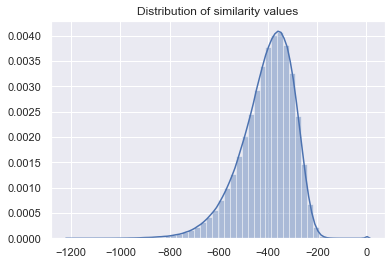

In [63]:
S = -squareform(pdist(reduced_fr_mat.T,'sqeuclidean')) # distance metric 
pref_min = int(round(np.min(S))) 
pref_med = int(round(np.median(S)))  
plt.figure() 
plt.title("Distribution of similarity values")
sns.distplot(S);


In [9]:
# visualize the discovered centroids # 
S = -squareform(pdist(reduced_fr_mat.T,'sqeuclidean')) # distance metric  
print(S.shape)
pref_min = int(round(np.min(S))) 
pref_med = int(round(np.median(S)))  
print('Median S: %f \n'%pref_med)
print('Min S: %f \n'%pref_min)

AP_clustering = AffinityPropagation(affinity = 'precomputed',preference = pref_min,random_state = 5,verbose = True) 
labels = AP_clustering.fit_predict(S) 
clusteroid_ix = AP_clustering.cluster_centers_indices_
clusteroid_ix 

(2145, 2145)
Median S: -390.000000 

Min S: -1207.000000 

Converged after 38 iterations.


array([ 112,  279,  292,  346,  555,  695,  710,  727,  806,  810,  845,
        876,  926,  960,  974, 1228, 1449, 1701, 1767, 1803, 1964, 2062])

Reduced Decision Variable Shape:  (2145,)
Reduced fr_mat Shape:  (305, 2145)


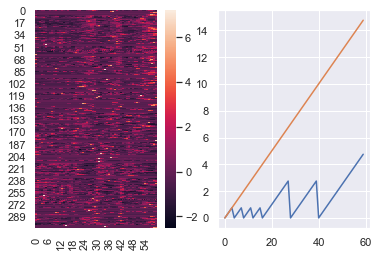

In [9]:
# get new indexing to look at dynamics
t_lens_reduced = np.floor(np.array(t_lens)/avg_window).astype(int)
leave_ix_reduced = np.cumsum(t_lens_reduced)  
stop_ix_reduced = leave_ix_reduced - t_lens_reduced 
test_trial = 38

# make down-sampled decision variables 
reduced_time = []
reduced_timeSince = []
timeSince = FR_decVar['decVarTimeSinceRew']
for trial in range(nTrials):
    timeSince_iTrial = timeSince[sIdx][0][trial].T
    trial_rews = np.floor((np.where(timeSince_iTrial == .02)[0][1:] + 1)* tbin_ms / avg_window_ms).astype(int)

    timeSince_iTrial_red = np.arange(0,t_lens_reduced[trial]) / (1000 / avg_window_ms) 
    time_iTrial_red = np.arange(0,t_lens_reduced[trial]) / (1000 / avg_window_ms) 
    for r in trial_rews: 
        if r < t_lens_reduced[trial]-2:
            timeSince_iTrial_red[r:] = np.arange(0,(t_lens_reduced[trial]-r)) / (1000 / avg_window_ms) 

    reduced_timeSince.append(timeSince_iTrial_red)
    reduced_time.append(time_iTrial_red) 
plt.figure() 
plt.subplot(1,2,1)
sns.heatmap(np.flipud(reduced_fr_mat[:,stop_ix_reduced[test_trial]:leave_ix_reduced[test_trial]])); 
plt.subplot(1,2,2)
plt.plot(reduced_timeSince[test_trial])
plt.plot(reduced_time[test_trial]); 

reduced_timeSince_full = np.concatenate(reduced_timeSince)
reduced_time_full = np.concatenate(reduced_time) 
# check that these match up
print("Reduced Decision Variable Shape: ",reduced_timeSince_full.shape) 
print("Reduced fr_mat Shape: ",reduced_fr_mat.shape)

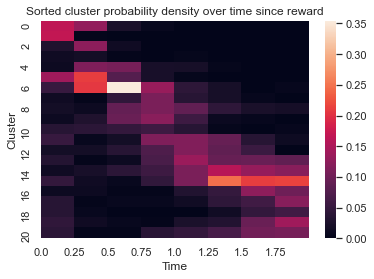

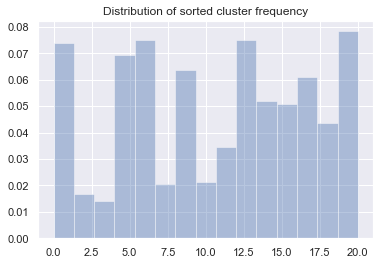

In [66]:
# Visualize cluster separability by timeSince 
bins = np.unique(labels)  
timepoints = np.arange(0,2,.25)
cluster_distns = np.zeros((len(bins)-1,len(timepoints)))
for i,t in enumerate(timepoints):
    cluster_distns[:,i] = np.histogram(labels[np.where(reduced_timeSince_full == t)[0]],bins = bins, density = True)[0]
peak_sort = np.argsort(np.argmax(cluster_distns,axis = 1))

plt.figure()
sns.heatmap(cluster_distns[peak_sort,:]) 
plt.xticks(range(len(timepoints)),timepoints); 
plt.xlabel("Time")
plt.ylabel("Cluster") 
plt.title("Sorted cluster probability density over time since reward")

sorted_labels = np.zeros(labels.shape) 
for i,c in enumerate(peak_sort): 
    label_ix = np.where(labels == c)[0]
    sorted_labels[label_ix] = i
plt.figure()  
plt.title("Distribution of sorted cluster frequency")
sns.distplot(sorted_labels,kde = False,norm_hist = True)



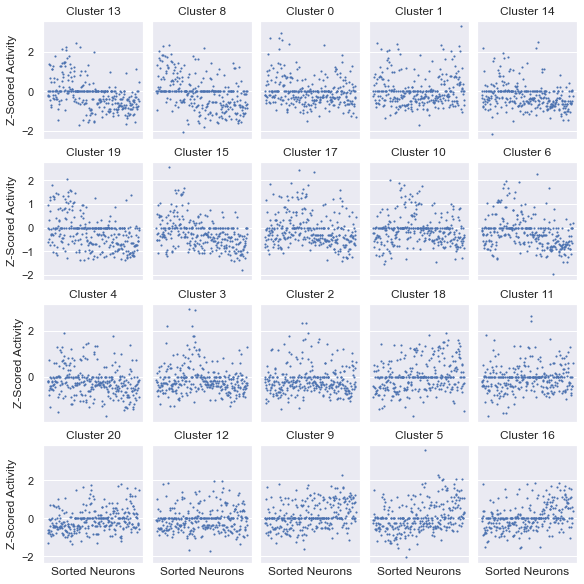

In [67]:
# check what the clusteroids look like, ordered by max density time
fig, axes = plt.subplots(int(np.ceil(len(clusteroid_ix[:20]) / 5)),5, sharey='row', sharex='col', constrained_layout=True,figsize=(8, 8))
for i,c_idx in enumerate(clusteroid_ix[peak_sort[:20]]): 
    row = int(np.floor(i / 5)) 
    col = i % 5
    axes[row,col].scatter(list(range(reduced_fr_mat.shape[0])),reduced_fr_mat[:,c_idx],marker = '.',s = 5) 
    axes[row,col].set_xticks([])
#     axes[row,col].set_yticks([])  
    axes[row,col].set_title("Cluster %i"%peak_sort[i])  
    if col == 0: 
        axes[row,col].set_ylabel("Z-Scored Activity") 
    if row == 3: 
        axes[row,col].set_xlabel("Sorted Neurons")


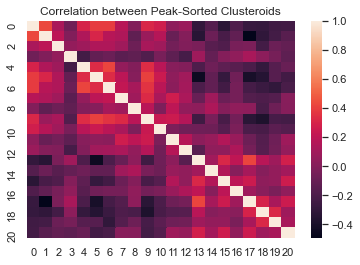

In [68]:
# Now, for our final trick, look at the cross correlation between clusters sorted by peak time 
clusteroids = np.zeros((reduced_fr_mat.shape[0],len(clusteroid_ix)-1)) 
for i,c_idx in enumerate(clusteroid_ix[peak_sort]): 
    clusteroids[:,i] = reduced_fr_mat[:,c_idx]
plt.figure() 
plt.title("Correlation between Peak-Sorted Clusteroids")
sns.heatmap(np.corrcoef(clusteroids.T));


## Now redo this clustering process, but clustering within timepoints
- maybe only mid-resp? but probably not!

S dimensionality: 271 x 271 

Median S: -143.000000 

Min S: -356.000000 

Test 0 complete 	
Test 5 complete 	
Test 10 complete 	
Test 15 complete 	
Test 20 complete 	


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "


Test 25 complete 	
S dimensionality: 271 x 271 

Median S: -122.000000 

Min S: -281.000000 

Test 0 complete 	
Test 5 complete 	
Test 10 complete 	
Test 15 complete 	


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "


Test 20 complete 	
S dimensionality: 271 x 271 

Median S: -126.000000 

Min S: -287.000000 

Test 0 complete 	
Test 5 complete 	
Test 10 complete 	
Test 15 complete 	
Test 20 complete 	
S dimensionality: 262 x 262 

Median S: -122.000000 

Min S: -318.000000 

Test 0 complete 	
Test 5 complete 	
Test 10 complete 	
Test 15 complete 	
Test 20 complete 	


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "


S dimensionality: 191 x 191 

Median S: -112.000000 

Min S: -308.000000 

Test 0 complete 	
Test 5 complete 	
Test 10 complete 	
Test 15 complete 	
Test 20 complete 	
Test 25 complete 	
S dimensionality: 182 x 182 

Median S: -98.000000 

Min S: -272.000000 

Test 0 complete 	
Test 5 complete 	
Test 10 complete 	
Test 15 complete 	
Test 20 complete 	
S dimensionality: 166 x 166 

Median S: -97.000000 

Min S: -250.000000 

Test 0 complete 	
Test 5 complete 	
Test 10 complete 	
Test 15 complete 	
Test 20 complete 	
S dimensionality: 149 x 149 

Median S: -95.000000 

Min S: -246.000000 

Test 0 complete 	
Test 5 complete 	
Test 10 complete 	
Test 15 complete 	
Test 20 complete 	


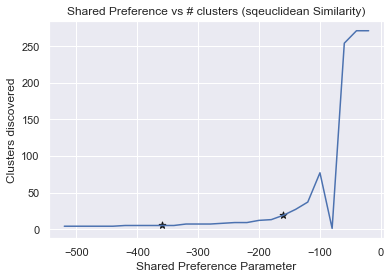

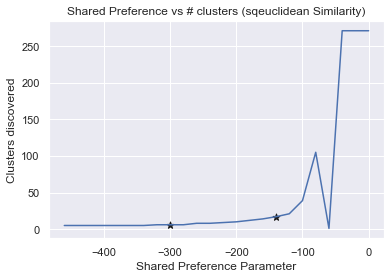

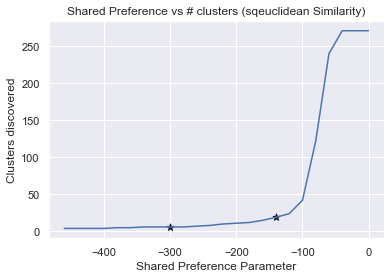

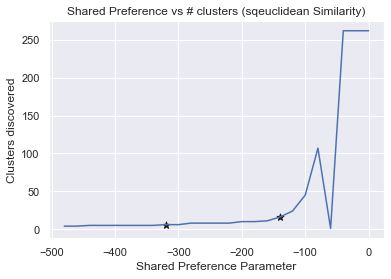

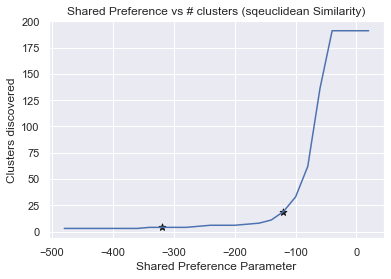

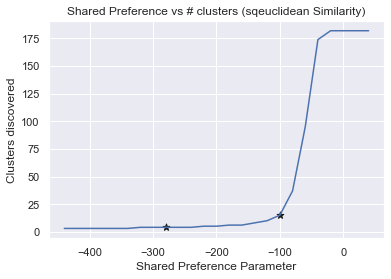

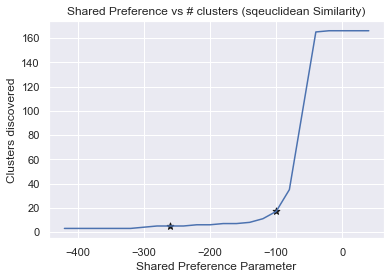

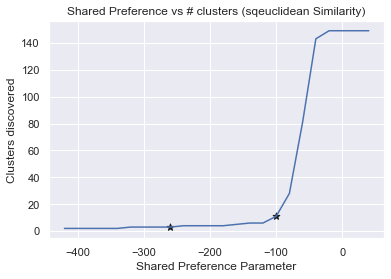

In [10]:
# first let's look at cluster discovery across shared preference parameter 
timepoints = np.arange(0,2,.25) 
for i,t in enumerate(timepoints):
    era_fr_mat = reduced_fr_mat[40:140,np.where(reduced_timeSince_full == t)[0]]
    S = -squareform(pdist(era_fr_mat.T,'sqeuclidean')) # distance metric  
    pref_tests,n_clusters = sharedPreferenceAssay(era_fr_mat.T,'sqeuclidean',160,20,data_pts = 'all',max_iter = 100) 


In [12]:
# the min looks pretty good for everyone, so let's move forward using min(S) as the shared preference param 
# can use median if results with min look uninteresting (acknowledge appropriately for scientific integrity) 
# can try this cluster overlap metrix that they have? 
timepoints = np.arange(0,3,.25)  
clusteroids = [] 
labels = -1 * np.ones(reduced_fr_mat.shape[1]) 
for i,t in enumerate(timepoints):
    era_fr_mat = reduced_fr_mat[40:140,np.where(reduced_timeSince_full == t)[0]]  
    S = -squareform(pdist(era_fr_mat.T,'sqeuclidean')) # distance metric    
    pref_min = np.min(S) 
    pref_med = np.median(S)
    AP_clustering = AffinityPropagation(affinity = 'precomputed',preference = pref_min,random_state = 5) 
    era_labels = AP_clustering.fit_predict(S)  
    labels[np.where(reduced_timeSince_full == t)[0]] = era_labels + i * 10 # note this won't work if we have > 10 clusters
    clusteroid_ix = AP_clustering.cluster_centers_indices_ 
    clusteroids.append(era_fr_mat[:,clusteroid_ix]) 



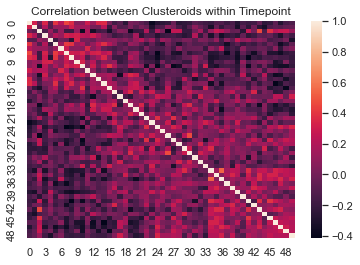

In [16]:
concat_clusteroids = np.concatenate(clusteroids,axis= 1)
plt.title("Correlation between Clusteroids within Timepoint")
sns.heatmap(np.corrcoef(concat_clusteroids.T));

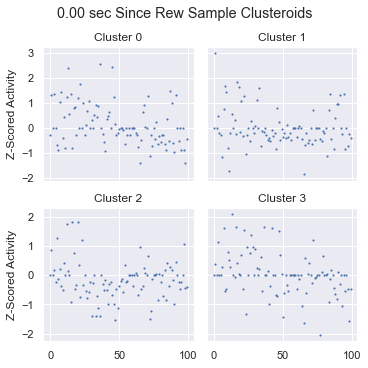

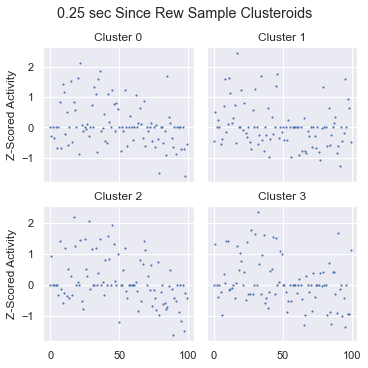

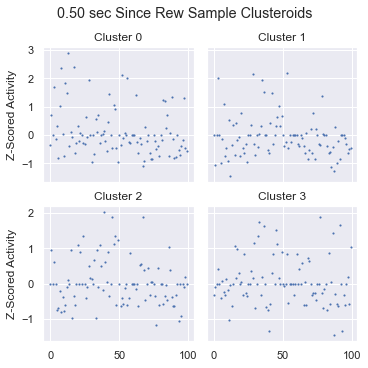

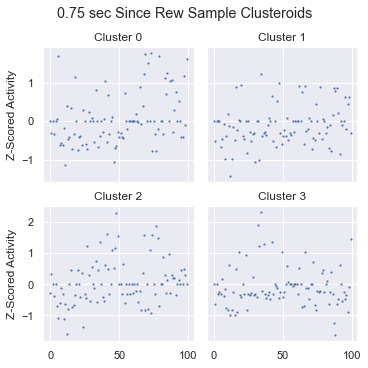

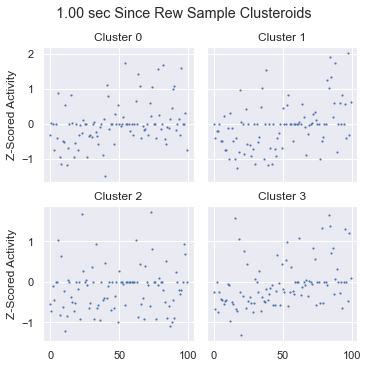

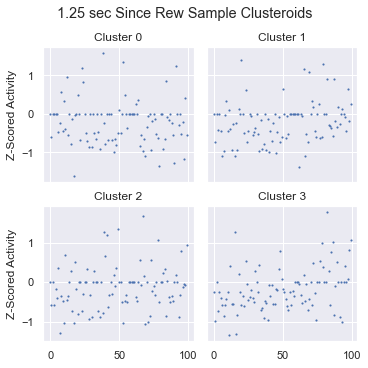

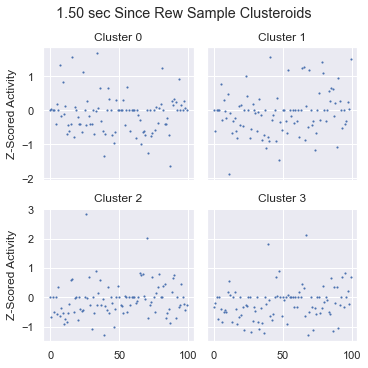

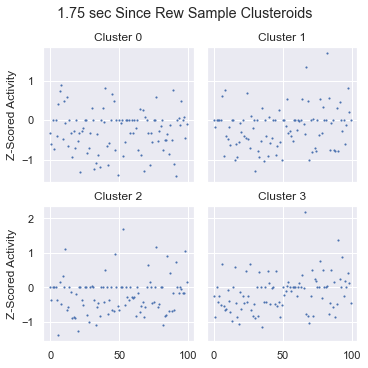

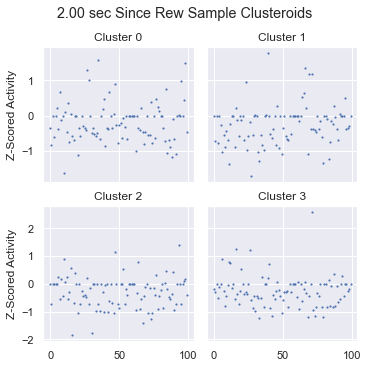

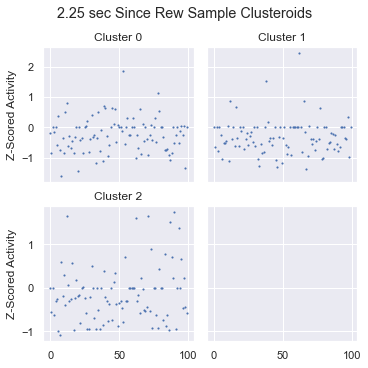

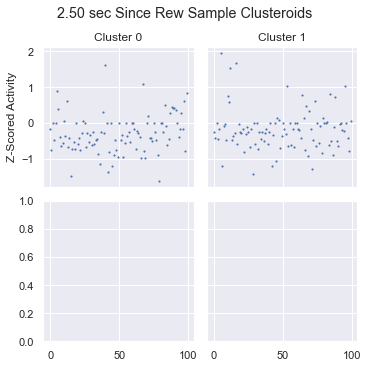

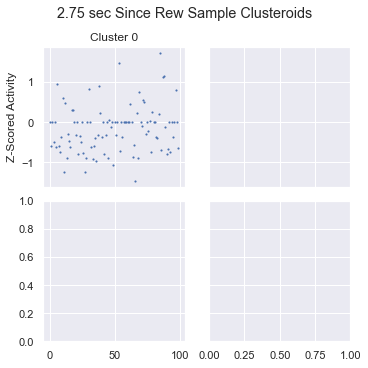

In [45]:
# Scatter plot activity clusteroids acr some indices
for e_idx in range(len(timepoints)):  
    fig, axes = plt.subplots(2,2, sharey='row', sharex='col', constrained_layout=True,figsize=(5,5)) 
    for c_idx in range(min(4,clusteroids[e_idx].shape[1])): 
        row = int(np.floor(c_idx / 2)) 
        col = c_idx % 2
        axes[row,col].scatter(list(range(100)),clusteroids[e_idx][:,c_idx],marker = '.',s = 5) 
#         axes[row,col].set_xticks()
    #     axes[row,col].set_yticks([])  
        axes[row,col].set_title("Cluster %i"%c_idx)  
        if col == 0: 
            axes[row,col].set_ylabel("Z-Scored Activity") 
        if row == 3: 
            axes[row,col].set_xlabel("Sorted Neurons") 
    plt.suptitle("{0:.2f} sec Since Rew Sample Clusteroids".format(timepoints[e_idx]))

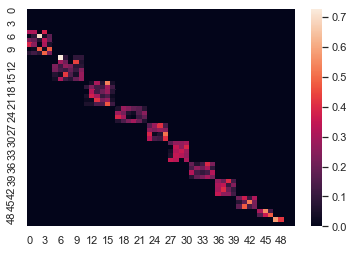

In [18]:
# construct graph of transitions, excluding transitions going over reward deliveries 
reduced_labels = -1 * np.ones(len(labels)) # reduced labels is labels from 0:# unique labels, no era distinctions
for i,l in enumerate(np.unique(labels[np.where(labels >= 0)[0]])):
    reduced_labels[np.where(labels == l)[0]] = i 

n_unique_labels = len(np.unique(reduced_labels))
T = np.zeros((n_unique_labels,n_unique_labels)) # "T[i,j] indicates transition from  j to i" 
leave_count = np.zeros(n_unique_labels) 
cluster_count = np.zeros(n_unique_labels)
for i, l in enumerate(reduced_labels[:-2]): 
    if (l >= 0) & (reduced_labels[i+1] >= 0) & (reduced_timeSince_full[i+1] > 0): # we aren't going to get a reward 
        T[int(reduced_labels[i+1]),int(l)] += 1 # add one to the counts 
    if (reduced_time_full[i+1] == 0) | (reduced_time_full[i+2] == 0): 
        leave_count[int(l)] += 1 
    cluster_count[int(l)] += 1

sum_T = np.sum(T,axis = 1)
T[np.where(sum_T > 0)[0],:] = T[np.where(sum_T > 0)[0],:] / sum_T[np.where(sum_T > 0)[0]][:,np.newaxis] 
p_leave = leave_count / cluster_count 
p_visit = cluster_count / np.sum(cluster_count)
sns.heatmap(T);
# sum_T

array([0.        , 1.95238095, 2.1       , 2.16438356, 2.24528302,
       2.        , 2.13043478, 2.14084507, 2.25      , 2.        ,
       2.14285714, 2.45454545, 2.02083333, 2.13114754, 2.16216216,
       2.05747126, 2.25925926, 2.39534884, 2.        , 2.2       ,
       2.1       , 2.2195122 , 2.05882353, 1.96296296, 2.15625   ,
       2.22727273, 2.27868852, 2.06896552, 2.3442623 , 2.2195122 ,
       2.1372549 , 2.46666667, 2.30434783, 2.16      , 2.32653061,
       2.15384615, 2.27083333, 2.53488372, 2.32258065, 2.25925926,
       2.6       , 2.44827586, 2.3       , 2.38709677, 2.63157895,
       2.4       , 2.65217391, 2.63888889, 2.68      , 2.68888889,
       0.        ])

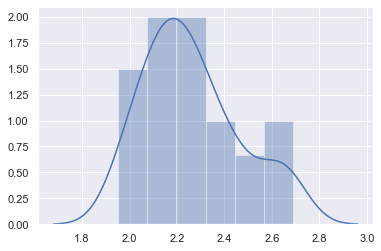

In [56]:
# make a reward size vector w/ the length of timeSinceReduced
rewsize = sio.loadmat('/Users/joshstern/Documents/UchidaLab_matlab/neuroPixelsData/80/rewsize80317.mat')['rewsize'].T[0] 
rewsize_concatTrials = []
for i,r in enumerate(rewsize.tolist()): 
    rewsize_concatTrials.append([r for j in range(t_lens_reduced[i])])  
rewsize_concatTrials = np.array([item for sublist in rewsize_concatTrials for item in sublist]) 
rewsize_concatTrials[np.where(rewsize_concatTrials == 4)[0]] = 3 # change to 3 to decr bias
mean_rewsizes = np.zeros(n_unique_labels)
for l in np.unique(reduced_labels): 
    if l > 0:
        mean_rewsizes[int(l)] = np.mean(rewsize_concatTrials[np.where(reduced_labels == l)[0]]) 
sns.distplot(mean_rewsizes[np.where(mean_rewsizes > 0)[0]],hist = True)
mean_rewsizes

0
5
6
6
6
4
4
5
4


Text(0.5, 1.0, 'Graph of Cluster Transitions')

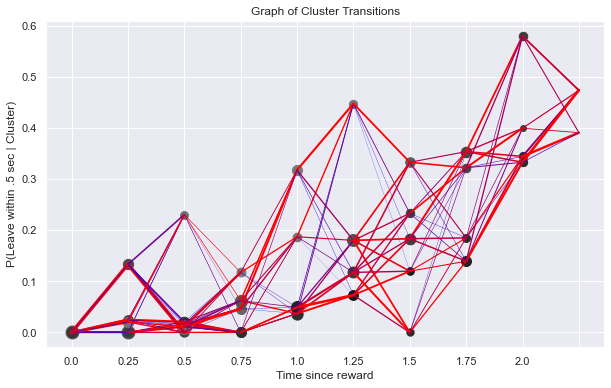

In [50]:
# visualize graph! 
n_eraClusts = [c.shape[1] for c in clusteroids]  
n_eraClusts.insert(0,0)
cumulativeClusts = np.cumsum(n_eraClusts) 
plt.figure(figsize = (10,6))
for i in range(len(n_eraClusts)-4): 
    print(n_eraClusts[i])
    sizes = 5000 * p_visit[cumulativeClusts[i]:cumulativeClusts[i+1]] 
#     plt.figure()
#     sns.heatmap(T[:,cumulativeClusts[i]:cumulativeClusts[i+1]])  
    if i < len(n_eraClusts)-4:
        for j in range(cumulativeClusts[i],cumulativeClusts[i+1]):
            for k in np.where(T[:,j] > 0)[0]:
                plt.figure(1) 
                lw = 5 * T[k,j] # linewidth is un-normalized 
                c = [(T[k,j] / np.max(T[:,j])),0,1 - (T[k,j] / np.max(T[:,j]))] # color is normalized
                # figure out how to deal with the p_leave of the next point
    #             print(k,j,lw)
                plt.plot([i,i+1],[p_leave[j],p_leave[k]],linewidth = lw,color = c) # plot line with transition
    plt.figure(1) 
    colors = [[1 - m / 3,1 - m / 3,1 - m / 3] for m in mean_rewsizes[cumulativeClusts[i]:cumulativeClusts[i+1]] ]
    for p,c,s in zip(p_leave[cumulativeClusts[i]:cumulativeClusts[i+1]],colors,sizes):
        plt.scatter(i,p,s = s,color = c)
plt.ylabel("P(Leave within .5 sec | Cluster)") 
plt.xlabel("Time since reward")
plt.xticks(list(range(len(n_eraClusts)-3)),timepoints[:-3])
plt.title("Graph of Cluster Transitions")


0
5
6
6
6
4
4
5
4


Text(0.5, 1.0, 'Graph of Shuffled Cluster Transitions')

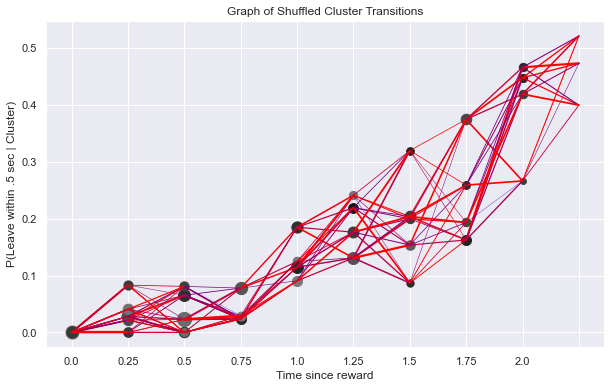

In [52]:
# Now perform shuffle control within era

timepoints = np.arange(0,3,.25)  
clusteroids = [] 
labels = -1 * np.ones(reduced_fr_mat.shape[1]) 
for i,t in enumerate(timepoints):
    era_fr_mat = reduced_fr_mat[40:140,np.where(reduced_timeSince_full == t)[0]]  
    S = -squareform(pdist(era_fr_mat.T,'sqeuclidean')) # distance metric    
    pref_min = np.min(S) 
    pref_med = np.median(S)
    AP_clustering = AffinityPropagation(affinity = 'precomputed',preference = pref_min,random_state = 5) 
    era_labels = AP_clustering.fit_predict(S) 
    np.random.shuffle(era_labels) # shuffle labels within era
    labels[np.where(reduced_timeSince_full == t)[0]] = era_labels + i * 10 # note this won't work if we have > 10 clusters
    clusteroid_ix = AP_clustering.cluster_centers_indices_ 
    clusteroids.append(era_fr_mat[:,clusteroid_ix]) 
#     plt.figure() 
#     plt.title("%f sec since reward clusteroids"%t)
#     sns.heatmap(clusteroids[i]) 

reduced_labels = -1 * np.ones(len(labels)) # reduced labels is labels from 0:# unique labels, no era distinctions
for i,l in enumerate(np.unique(labels[np.where(labels >= 0)[0]])):
    reduced_labels[np.where(labels == l)[0]] = i 

n_unique_labels = len(np.unique(reduced_labels))
T = np.zeros((n_unique_labels,n_unique_labels)) # "T[i,j] indicates transition from  j to i" 
leave_count = np.zeros(n_unique_labels) 
cluster_count = np.zeros(n_unique_labels) 
for i, l in enumerate(reduced_labels[:-2]): 
    if (l >= 0) & (reduced_labels[i+1] >= 0) & (reduced_timeSince_full[i+1] > 0): # we aren't going to get a reward 
        T[int(reduced_labels[i+1]),int(l)] += 1 # add one to the counts 
    if (reduced_time_full[i+1] == 0) | (reduced_time_full[i+2] == 0): 
        leave_count[int(l)] += 1 
    cluster_count[int(l)] += 1
    
sum_T = np.sum(T,axis = 1)
T[np.where(sum_T > 0)[0],:] = T[np.where(sum_T > 0)[0],:] / sum_T[np.where(sum_T > 0)[0]][:,np.newaxis] 
p_leave = leave_count / cluster_count 
p_visit = cluster_count / np.sum(cluster_count)

# visualize fake graph
n_eraClusts = [c.shape[1] for c in clusteroids]  
n_eraClusts.insert(0,0)
cumulativeClusts = np.cumsum(n_eraClusts) 
plt.figure(figsize = (10,6))
for i in range(len(n_eraClusts)-4): 
    print(n_eraClusts[i])
    sizes = 5000 * p_visit[cumulativeClusts[i]:cumulativeClusts[i+1]] 
#     plt.figure()
#     sns.heatmap(T[:,cumulativeClusts[i]:cumulativeClusts[i+1]])  
    if i < len(n_eraClusts)-4:
        for j in range(cumulativeClusts[i],cumulativeClusts[i+1]):
            for k in np.where(T[:,j] > 0)[0]:
                plt.figure(1) 
                lw = 5 * T[k,j] # linewidth is un-normalized 
                c = [(T[k,j] / np.max(T[:,j])),0,1 - (T[k,j] / np.max(T[:,j]))] # color is normalized
                # figure out how to deal with the p_leave of the next point
    #             print(k,j,lw)
                plt.plot([i,i+1],[p_leave[j],p_leave[k]],linewidth = lw,color = c) # plot line with transition
    plt.figure(1) 
    colors = [[1 - m / 3,1 - m / 3,1 - m / 3] for m in mean_rewsizes[cumulativeClusts[i]:cumulativeClusts[i+1]] ]
    for p,c,s in zip(p_leave[cumulativeClusts[i]:cumulativeClusts[i+1]],colors,sizes):
        plt.scatter(i,p,s = s,color = c)
plt.ylabel("P(Leave within .5 sec | Cluster)") 
plt.xlabel("Time since reward")
plt.xticks(list(range(len(n_eraClusts)-3)),timepoints[:-3])
plt.title("Graph of Shuffled Cluster Transitions")

## Ok let's see if we can do this within just first second of R... Trials

## garbage

In [33]:
# use a custom distance function for scipy pdist
def dfun(u, v):
    return np.sqrt(((u-v)**2).sum())

dm = pdist(X, lambda u, v: np.sqrt(((u-v)**2).sum()))

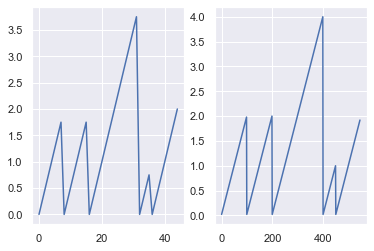

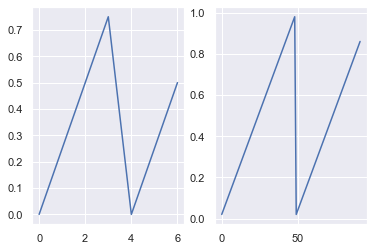

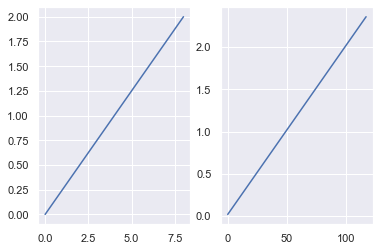

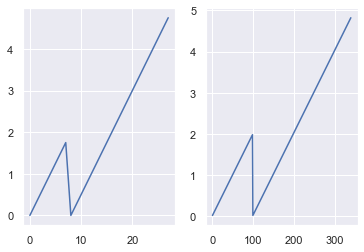

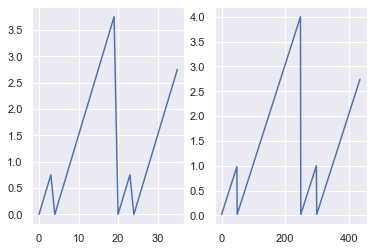

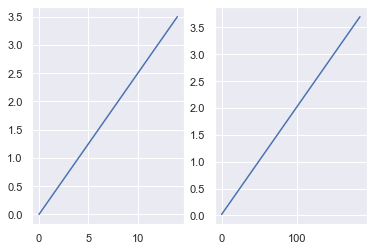

In [1090]:
timeSince = FR_decVar['decVarTimeSinceRew'][0] 
for trial in [20,21,22,23,24,25]:
    timeSince_iTrial = timeSince[trial].T
    trial_rews = np.floor((np.where(timeSince_iTrial == .02)[0][1:] + 1)* tbin_ms / avg_window_ms).astype(int)

    timeSince_iTrial_red = np.arange(0,t_lens_reduced[trial]) / (1000 / avg_window_ms)
    for r in trial_rews: 
        if r < t_lens_reduced[trial]-2:
            timeSince_iTrial_red[r:] = np.arange(0,(t_lens_reduced[trial]-r)) / (1000 / avg_window_ms) 
    plt.figure() 
    plt.subplot(1,2,1)
    plt.plot(timeSince_iTrial_red) 
    plt.subplot(1,2,2)
    plt.plot(timeSince[trial].T);

In [235]:
#!/usr/bin/env python
import psutil
# gives a single float value
psutil.cpu_percent()
# gives an object with many fields
psutil.virtual_memory()
# you can convert that object to a dictionary 
dict(psutil.virtual_memory()._asdict())

{'total': 17179869184,
 'available': 5828530176,
 'percent': 66.1,
 'used': 8902520832,
 'free': 196554752,
 'active': 5831905280,
 'inactive': 5390192640,
 'wired': 3070615552}

In [234]:
del d

In [20]:
n_eraClusts = [c.shape[1] for c in clusteroids]   
n_eraClusts

[5, 6, 6, 6, 4, 4, 5, 4, 4, 3, 2, 1]